In [ ]:
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from google.colab import drive
import pandas as pd
import plotly.express as px
import os
import json
import re
import pickle
import sklearn
from pathlib import Path
import time
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import numpy as np
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

## Description
This notebook presents the results of classification (pos/neg) of the reviews from the Booking.com dataset.  The classification was performed using MLP and transfer learning between languages in different configurations.

In [ ]:
drive_path = '/content/drive/'
BASE_DIR = drive_path + 'MyDrive/ColabNotebooks/studia/NLP/L3'
drive.mount(drive_path, force_remount=True)
log_dir = BASE_DIR + '/logs/'
FIGURES_DIR = BASE_DIR + "/figures"

DATAFRAMES_DIR = os.path.join(BASE_DIR, "dataframes")
RESULTS_DIR = os.path.join(BASE_DIR, "results_dfs")
LASER_PL_PATH = os.path.join(DATAFRAMES_DIR, "Laser_pl.tar.gz")
LASER_ENG_PATH = os.path.join(DATAFRAMES_DIR, "Laser_eng.tar.gz")

Mounted at /content/drive/


## Model klasyfikacji

In [ ]:
class training_set(torch.utils.data.Dataset):
    def __init__(self,X,Y):
        self.X = torch.from_numpy(X).float()                          
        self.Y = torch.from_numpy(Y).float()                     

    def __len__(self):
        return len(self.X)                   

    def __getitem__(self, idx):
      return [self.X[idx], self.Y[idx]] 

def to_dl(x, y):
  train_data = training_set(x, y)
  return torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

def empty_results():
    return {
            "precision": [],
            "f1-score": [],
            "recall": [],
            "accuracy": [],
        }


class BookingClassifier(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    def __init__(self, epochs=30, in_dim=1024, hid_dim=100, layers=2, epochs_after=20, report_every=2, **kwargs):
        self.epochs = epochs
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.layers = layers
        self.init_model()
        self.optimiser = optim.Adam(self.model.parameters())
        self.loss_fn = torch.nn.BCELoss()
        self.epochs_after = epochs_after
        self.report_every = report_every
        self.ln2_results = empty_results()
        self.ln1_results = empty_results()

    def init_model(self):
        self.model = nn.Sequential()
        curr_in = self.in_dim
        for i in range(self.layers):
            self.model.add_module(f"lin_{i}", torch.nn.Linear(curr_in, self.hid_dim)) 
            self.model.add_module(f"lin_{i}_act" , torch.nn.ReLU())
            curr_in = self.hid_dim

        self.model.add_module("lin_last", torch.nn.Linear(curr_in, 1)) 
        self.model.add_module("last_sigm" , torch.nn.Sigmoid())
        self.model.cuda()

    def fit(self, X, y):
        train_dl = to_dl(X, y)
        for epoch in range(self.epochs):
            for X_batch, y_batch in train_dl:
                y_pred = self.model(X_batch.cuda())
                loss = self.loss_fn(y_pred.squeeze(), y_batch.cuda())
                loss.backward()
                self.optimiser.step()
                self.optimiser.zero_grad() 
        return self

    def predict(self, X):
        return torch.round(self.model(torch.from_numpy(X).float().cuda()).detach().cpu()).numpy()


    def update_report(self, X_ln1, y_ln1, X_ln2, y_ln2):

        ln1_pred = self.predict(X_ln1)
        ln1_report = classification_report(y_ln1, ln1_pred, output_dict=True)
        self.ln1_results["precision"].append(ln1_report['macro avg']['precision'])
        self.ln1_results["f1-score"].append(ln1_report['macro avg']['f1-score'])
        self.ln1_results["recall"].append(ln1_report['macro avg']['recall'])
        self.ln1_results["accuracy"].append(ln1_report['accuracy'])

        ln2_pred = self.predict(X_ln2)
        ln2_report = classification_report(y_ln2, ln2_pred, output_dict=True)
        self.ln2_results["precision"].append(ln2_report['macro avg']['precision'])
        self.ln2_results["f1-score"].append(ln2_report['macro avg']['f1-score'])
        self.ln2_results["recall"].append(ln2_report['macro avg']['recall'])
        self.ln2_results["accuracy"].append(ln2_report['accuracy'])
        

    def additional_fit(self, X, y, X_ln1, y_ln1, X_ln2, y_ln2):
        self.update_report(X_ln1, y_ln1, X_ln2, y_ln2)
        if X.shape[0] == 0:
            return self
        train_dl = to_dl(X, y)
        for i, epoch in enumerate(range(self.epochs_after)):
            for X_batch, y_batch in train_dl:
                y_pred = self.model(X_batch.cuda())
                loss = self.loss_fn(y_pred.squeeze(), y_batch.cuda())
                loss.backward()
                self.optimiser.step()
                self.optimiser.zero_grad()
            if (i+1) % self.report_every == 0:
                self.update_report(X_ln1, y_ln1, X_ln2, y_ln2)
        return self



## Uczenie i wyniki

In [ ]:
def get_training_data(df, column, max_samples):
    df = df[df[column].notnull()].sample(max_samples, random_state=1)
    return np.array(df[column].values.tolist())

def load_embeddings(path, max_samples_per_class=100):
    df = pd.read_pickle(path)
    x_res = []
    y_res = []
    for y_val, col in [(1, "vec_positive"), (0, "vec_negative")]:
        x = get_training_data(df, col, max_samples_per_class)
        x_res.append(x)
        y_res.append(np.full((x.shape[0], 1), y_val))
    
    return np.concatenate(x_res, axis=0), np.concatenate(y_res, axis=0).ravel()

In [ ]:
class SplitData():
    
    def __init__(self, X, y, splits, seed):
        self.data_X = []
        self.data_y = []
        self.sizes=[]
        size = X.shape[0]
        rest_X = X
        rest_y = y
        for split in splits:
            self.sizes.append(int(split*size))
            if split == 0.0 or split == 0:
                next_X = np.zeros((0, rest_X.shape[1]))
                next_y = np.zeros((0))
            else:
                next_X, rest_X, next_y, rest_y = train_test_split(rest_X, rest_y, train_size = int(split*size), stratify=rest_y, random_state=seed)
            self.data_X.append(next_X)
            self.data_y.append(next_y)

    def get(self, index):
        return self.data_X[index], self.data_y[index] 

def concat_data(ln1_data, ln2_data):
    result_X = np.concatenate((ln1_data[0], ln2_data[0]), axis=0)
    result_y = np.concatenate((ln1_data[1], ln2_data[1]), axis=0)    
    return result_X, result_y

In [ ]:
# funkcja do odpalenia pojedynczego eksperymentu

def test_transfer_learning(split_ln1, split_ln2, params):
    base_X, base_y = concat_data(split_ln1.get(0), split_ln2.get(0))
    sec_X, sec_y = concat_data(split_ln1.get(1), split_ln2.get(1))
    X_ln1, y_ln1 = split_ln1.get(2)
    X_ln2, y_ln2 = split_ln2.get(2)
    model = BookingClassifier(**params)
    model = model.fit(base_X, base_y)
    model = model.additional_fit(sec_X, sec_y, X_ln1, y_ln1, X_ln2, y_ln2)
    return model.ln1_results, model.ln2_results

def result_df(results_ln1, name_1, results_ln2, name2, report_every):
    data_ln1 = {'epoch': range(0, len(results_ln1['precision']) * report_every, report_every),
        'precision': results_ln1['precision'],
        'f1-score': results_ln1['f1-score'],
        'recall': results_ln1['recall'],
        'accuracy': results_ln1['accuracy'],
        'lang': [name_1]*len(results_ln1['precision'])}

    data_ln2 = {'epoch': range(0, len(results_ln2['precision']) * report_every, report_every),
        'precision': results_ln2['precision'],
        'f1-score': results_ln2['f1-score'],
        'recall': results_ln2['recall'],
        'accuracy': results_ln2['accuracy'],
        'lang': [name2]*len(results_ln2['precision'])}

    df_1 = pd.DataFrame(data_ln1)
    df_2 = pd.DataFrame(data_ln2)
    df_all = pd.concat([df_1, df_2]).reset_index(drop=True)
    return df_all

def visualize_results(results_df, title, exp_name):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
    fig.suptitle(title, fontsize=15)
    axs[0][0].title.set_text("precision")
    sns.lineplot(x='epoch', y='precision', hue='lang', 
                data=results_df, ax=axs[0][0])
    axs[0][1].title.set_text("F1-score")
    sns.lineplot(x='epoch', y='f1-score', hue='lang', 
                data=results_df, ax=axs[0][1])
    axs[1][0].title.set_text("Recall")
    sns.lineplot(x='epoch', y='recall', hue='lang', 
                data=results_df, ax=axs[1][0])
    axs[1][1].title.set_text("Accuracy")
    sns.lineplot(x='epoch', y='accuracy', hue='lang', 
                data=results_df, ax=axs[1][1])
    plt.savefig(os.path.join(FIGURES_DIR, f'{exp_name}.png'))
    plt.show()

In [ ]:
def full_experiment(split_fn1, ln1_name, split_fn2, ln2_name, params, repeats=5, exp_name=None, exp_title=None):
    main_df = None
    for seed in range(repeats):
        split_ln1 = split_fn1(seed)
        split_ln2 = split_fn2(20+seed)
        results_ln1, results_ln2 = test_transfer_learning(split_ln1, split_ln2, params)
        df = result_df(results_ln1, ln1_name, results_ln2, ln2_name, params["report_every"])
        if main_df is None:
            main_df = df
        else:
            main_df[["precision", "f1-score", "recall", "accuracy"]] = \
                main_df[["precision", "f1-score", "recall", "accuracy"]] + \
                df[["precision", "f1-score", "recall", "accuracy"]]
    main_df[["precision", "f1-score", "recall", "accuracy"]] = \
        main_df[["precision", "f1-score", "recall", "accuracy"]] / repeats
    main_df.to_pickle(os.path.join(RESULTS_DIR, f'{exp_name}.pkl'))
    visualize_results(df, exp_title, exp_name)

In [ ]:
X_en, y_en =  load_embeddings(LASER_ENG_PATH, max_samples_per_class=30000)
X_pl, y_pl =  load_embeddings(LASER_PL_PATH, max_samples_per_class=30000)

In [ ]:
params = {
    "epochs" : 50,
    "in_dim" : 1024,
    "hid_dim" : 200,
    "layers" : 2,
    "epochs_after" : 50,
    "report_every" : 2  
}

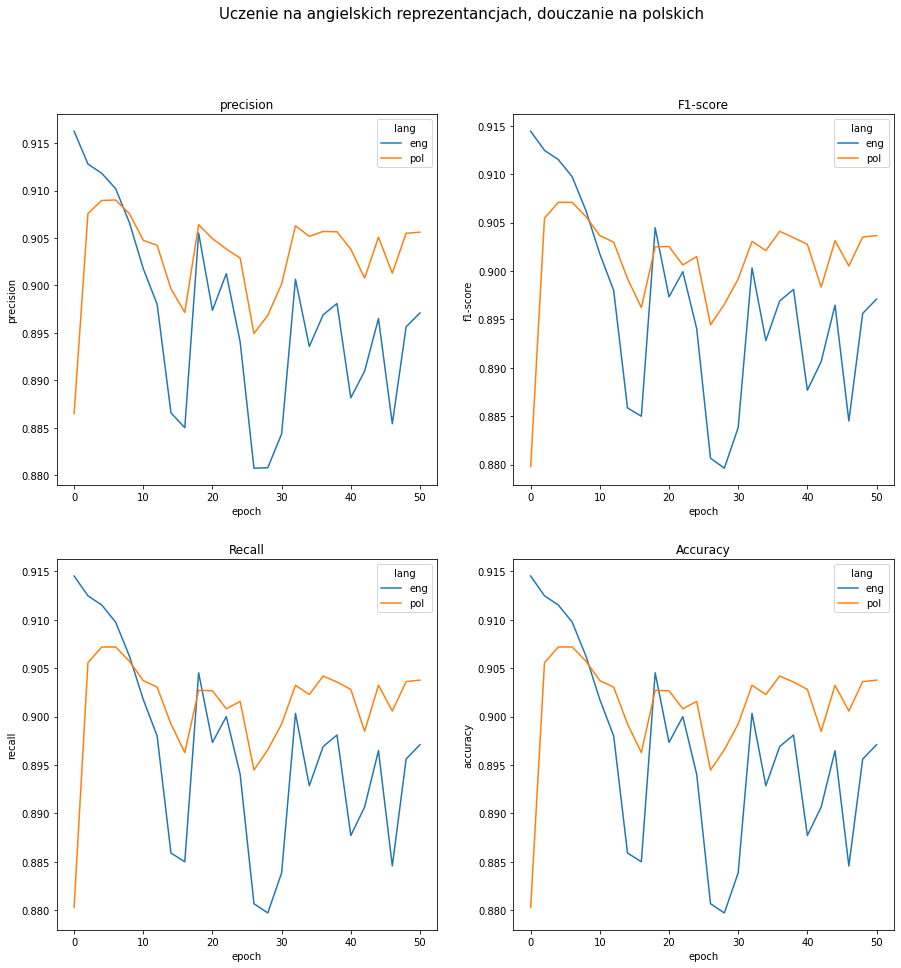

In [ ]:
split_eng = lambda seed : SplitData(X_en, y_en, [0.6, 0.0, 0.35], seed)
split_pl = lambda seed: SplitData(X_pl, y_pl, [0.0, 0.3, 0.35], seed)

full_experiment(split_eng, 'eng', split_pl, 'pol', params, 
                repeats = 10, exp_name = 'eng_100_0', 
                exp_title = 'Uczenie na angielskich reprezentancjach, douczanie na polskich')

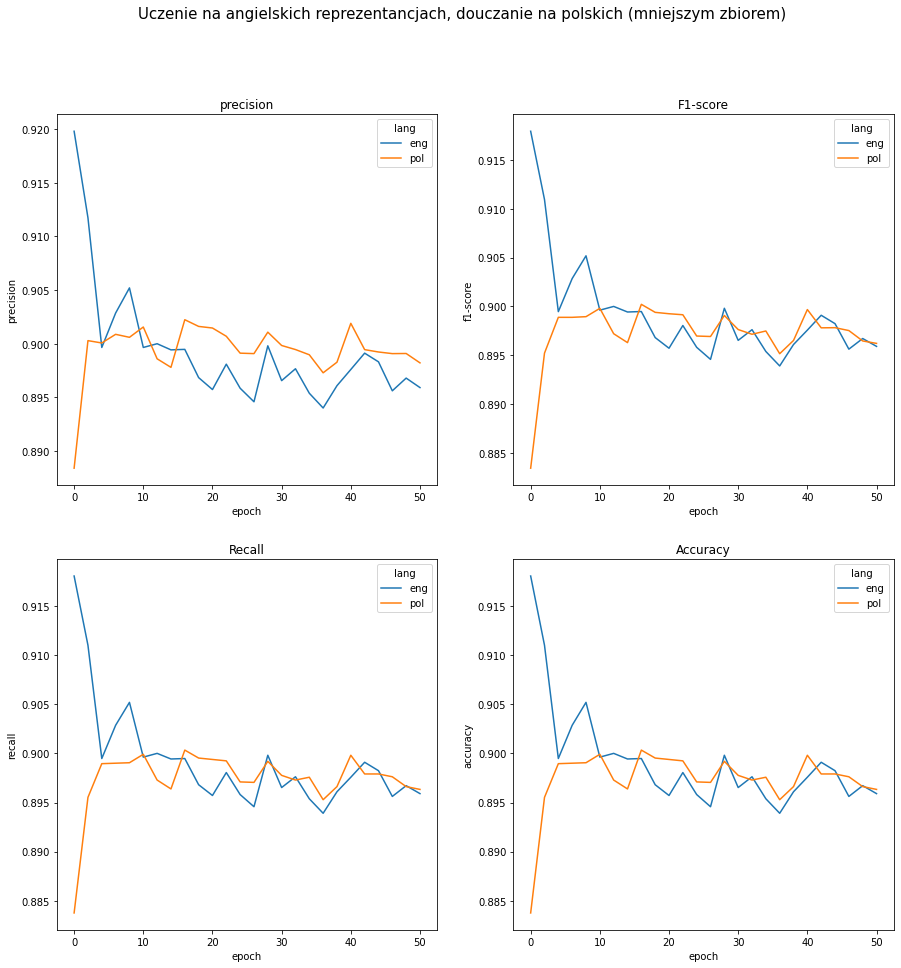

In [ ]:
split_eng = lambda seed : SplitData(X_en, y_en, [0.6, 0.0, 0.35], seed)
split_pl = lambda seed: SplitData(X_pl, y_pl, [0.0, 0.05, 0.35], seed)

full_experiment(split_eng, 'eng', split_pl, 'pol', params, 
                repeats = 10, exp_name = 'eng_100_0_mini', 
                exp_title = 'Uczenie na angielskich reprezentancjach, douczanie na polskich (mniejszym zbiorem)')

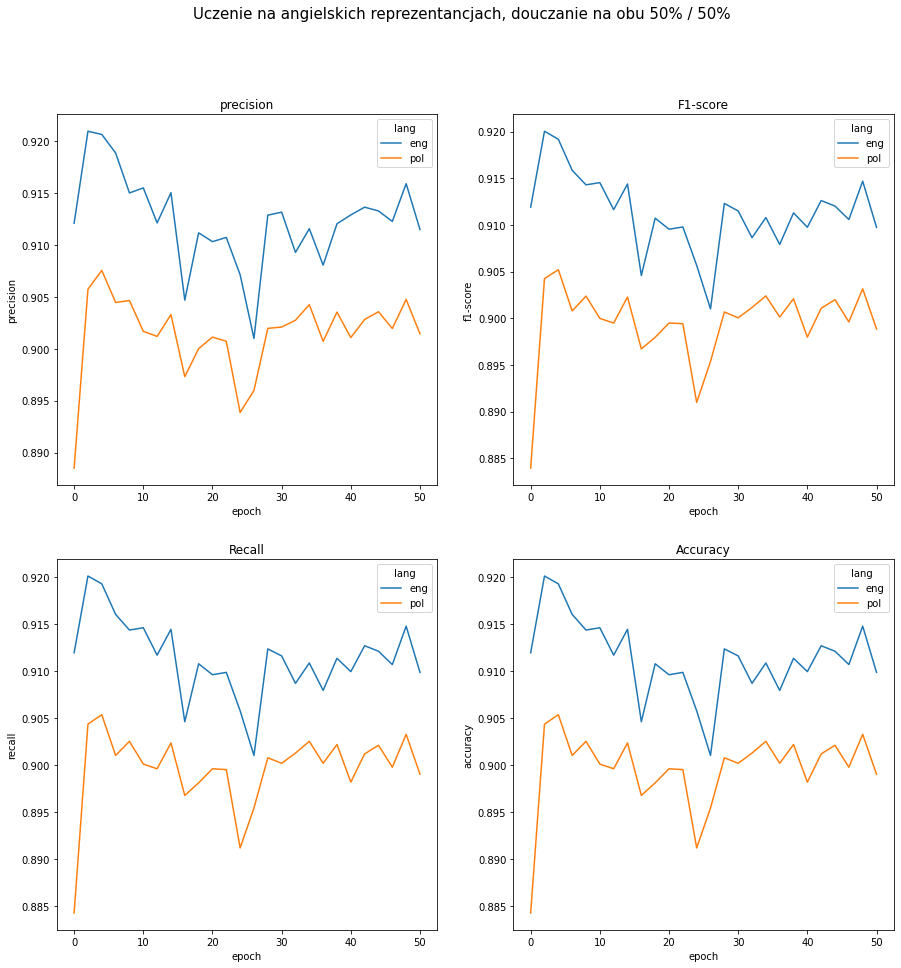

In [ ]:
split_eng = lambda seed : SplitData(X_en, y_en, [0.6, 0.15, 0.2], seed)
split_pl = lambda seed: SplitData(X_pl, y_pl, [0.0, 0.15, 0.2], seed)

full_experiment(split_eng, 'eng', split_pl, 'pol', params, 
                repeats = 10, exp_name = 'eng_50_50', 
                exp_title = 'Uczenie na angielskich reprezentancjach, douczanie na obu 50% / 50%')

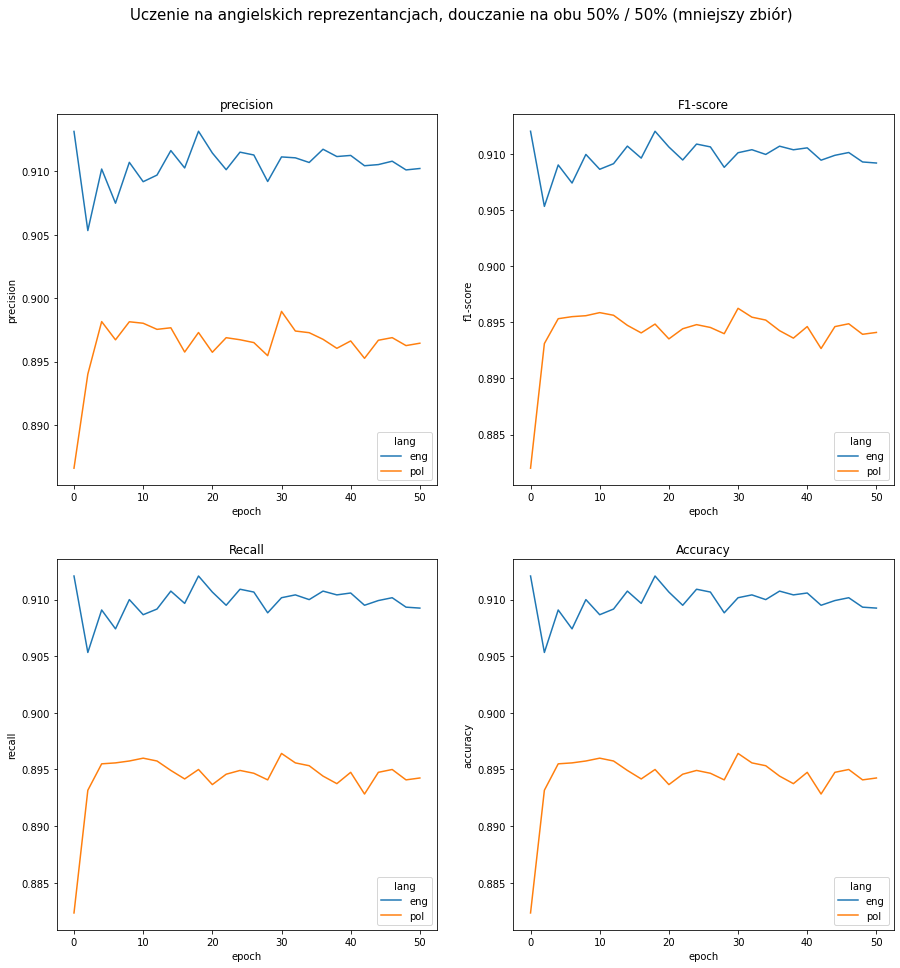

In [ ]:
split_eng = lambda seed : SplitData(X_en, y_en, [0.6, 0.025, 0.2], seed)
split_pl = lambda seed: SplitData(X_pl, y_pl, [0.0, 0.025, 0.2], seed)

full_experiment(split_eng, 'eng', split_pl, 'pol', params, 
                repeats = 10, exp_name = 'eng_50_50_mini', 
                exp_title = 'Uczenie na angielskich reprezentancjach, douczanie na obu 50% / 50% (mniejszy zbiór)')

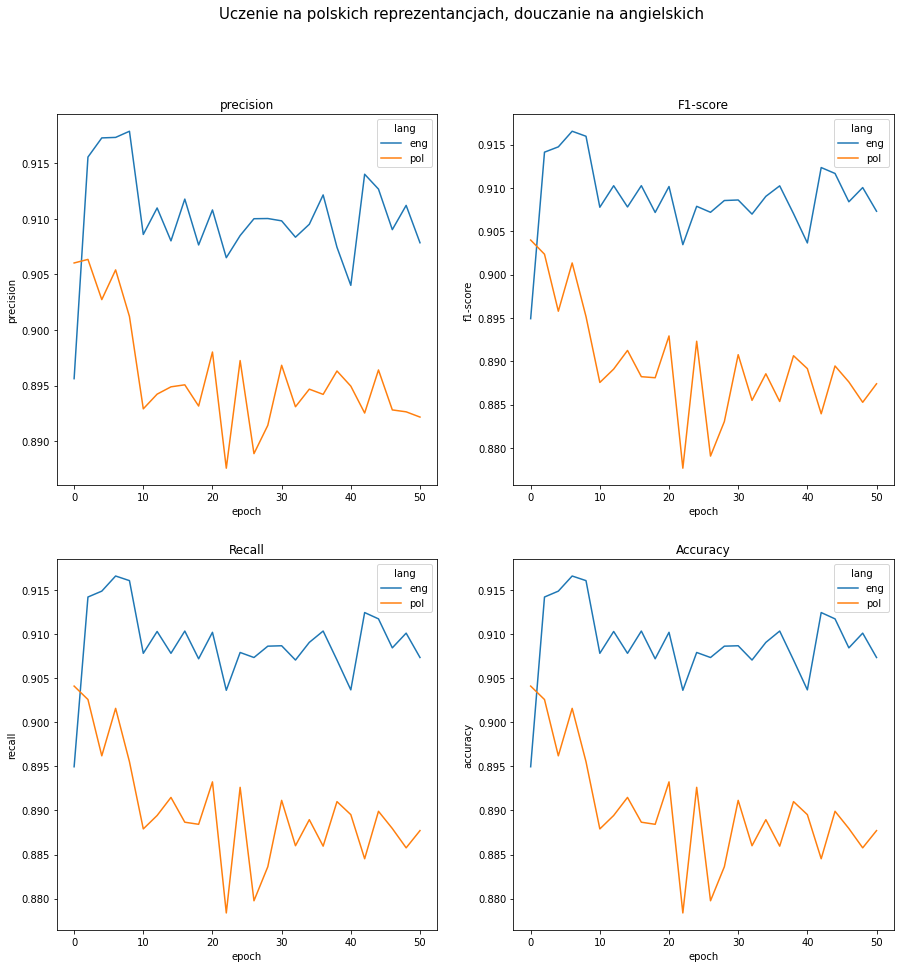

In [ ]:
split_eng = lambda seed : SplitData(X_en, y_en, [0, 0.3, 0.35], seed)
split_pl = lambda seed: SplitData(X_pl, y_pl, [0.6, 0.0, 0.35], seed)

full_experiment(split_eng, 'eng', split_pl, 'pol', params, 
                repeats = 10, exp_name = 'pol_100_0', 
                exp_title = 'Uczenie na polskich reprezentancjach, douczanie na angielskich')

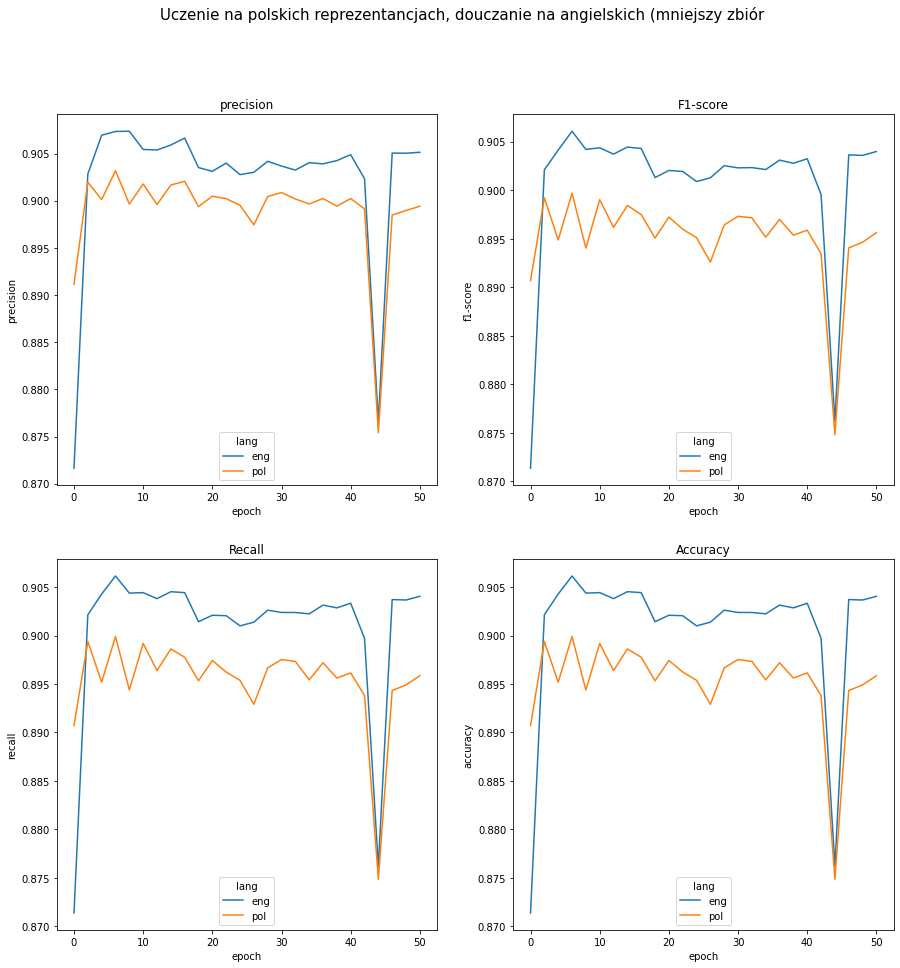

In [ ]:
split_eng = lambda seed : SplitData(X_en, y_en, [0, 0.05, 0.35], seed)
split_pl = lambda seed: SplitData(X_pl, y_pl, [0.6, 0.0, 0.35], seed)

full_experiment(split_eng, 'eng', split_pl, 'pol', params, 
                repeats = 10, exp_name = 'pol_100_0_mini', 
                exp_title = 'Uczenie na polskich reprezentancjach, douczanie na angielskich (mniejszy zbiór')

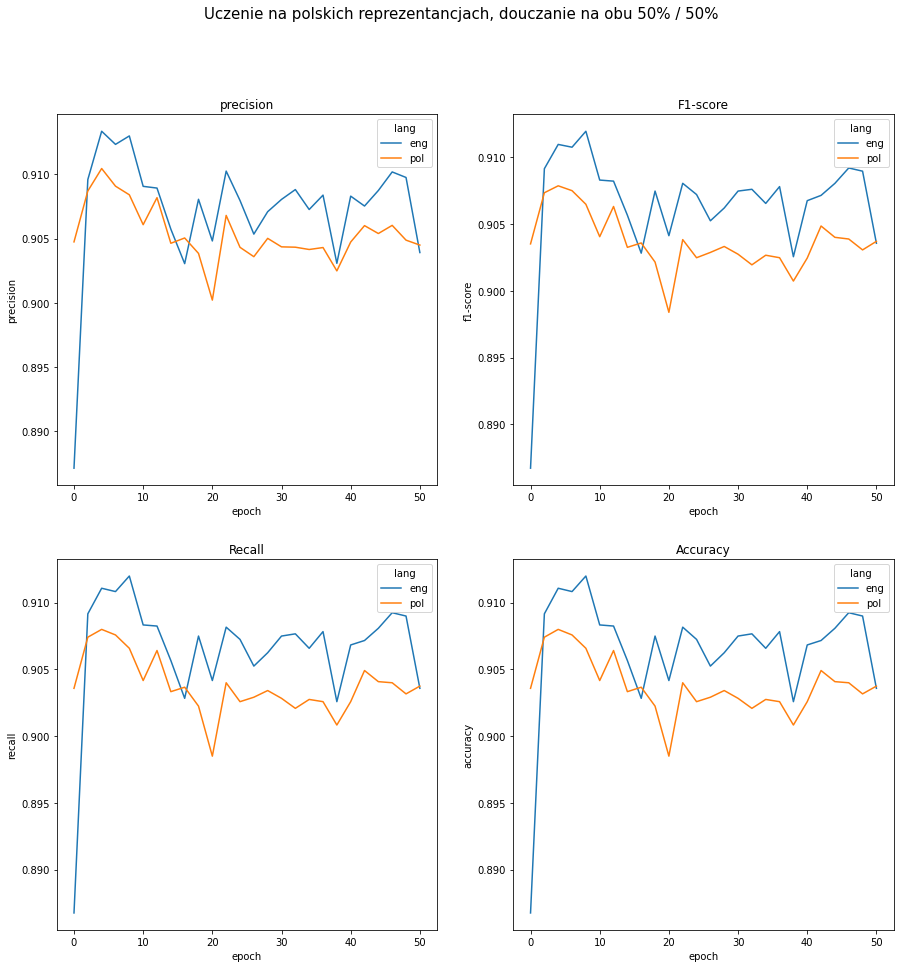

In [ ]:
split_eng = lambda seed : SplitData(X_en, y_en, [0.0, 0.15, 0.2], seed)
split_pl = lambda seed: SplitData(X_pl, y_pl, [0.6, 0.15, 0.2], seed)

full_experiment(split_eng, 'eng', split_pl, 'pol', params, 
                repeats = 10, exp_name = 'pol_50_50', 
                exp_title = 'Uczenie na polskich reprezentancjach, douczanie na obu 50% / 50%')

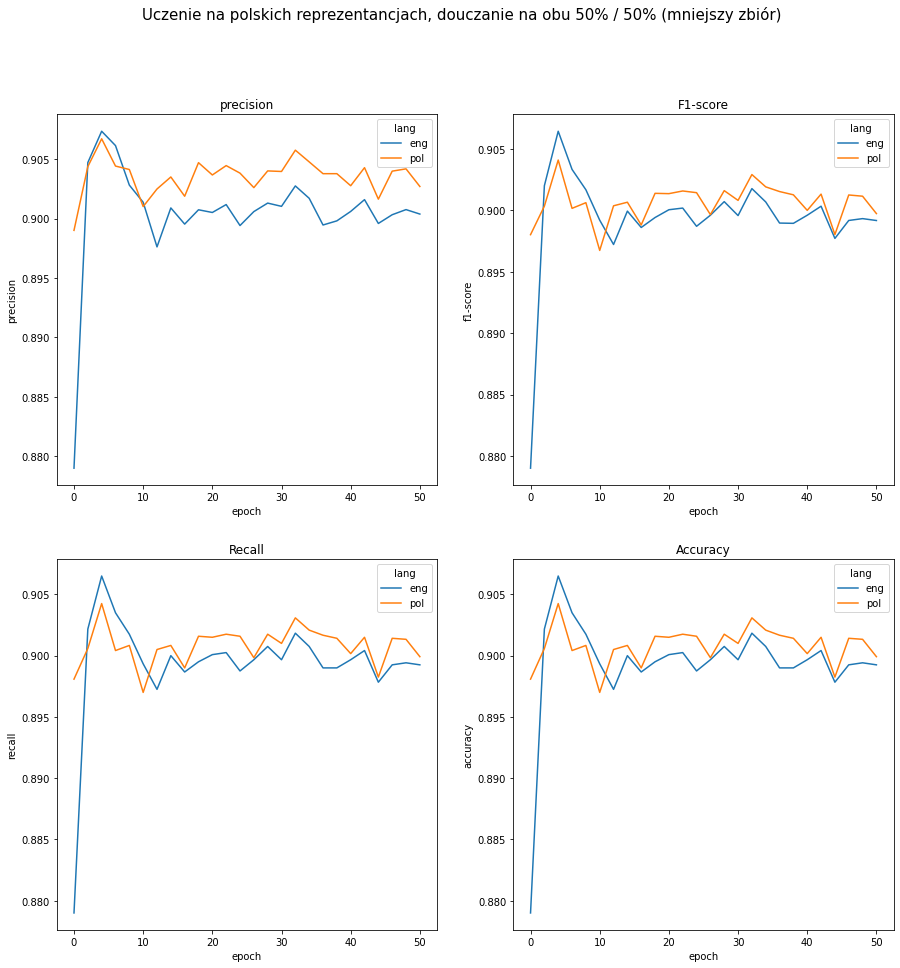

In [ ]:
split_eng = lambda seed : SplitData(X_en, y_en, [0.0, 0.025, 0.2], seed)
split_pl = lambda seed: SplitData(X_pl, y_pl, [0.6, 0.025, 0.2], seed)

full_experiment(split_eng, 'eng', split_pl, 'pol', params, 
                repeats = 10, exp_name = 'pol_50_50_mini', 
                exp_title = 'Uczenie na polskich reprezentancjach, douczanie na obu 50% / 50% (mniejszy zbiór)')
